## Evaluating the switch Bowtie2

**20170515**

Taken from [the Bowtie2 FAQ web page](http://bowtie-bio.sourceforge.net/bowtie2/faq.shtml), the main differences between Bowtie and Bowtie2 are:
* Bowtie 2 fully supports gapped alignment with affine gap penalties. Number of gaps and gap lengths are not restricted, except via the user-supplied scoring scheme. Bowtie 1 only finds ungapped alignments.
* For reads longer than about 50 bp Bowtie 2 is generally faster, more sensitive, and uses less memory than Bowtie * For relatively short reads (e.g. less than 50 bp) Bowtie 1 is sometimes faster and/or more sensitive.
* Bowtie 2 supports a "local" alignment mode, which doesn't require that reads align end-to-end. This produces alignments that might be "trimmed" (or "soft clipped") at one or both extremes in a way that optimizes alignment score. Bowtie 2 also supports an "end-to-end" alignment mode which, like Bowtie 1, requires that the read align entirely.
* There is no upper limit on read length in Bowtie 2. Bowtie 1 had an upper limit of around 1000 bp.
* Bowtie 2 does away with Bowtie 1's notion of alignment "stratum". In Bowtie 2 all alignments lie along a continuous spectrum of alignment scores.
* There is no longer a distinction between "end-to-end" and "Maq-like" modes as in Bowtie 1. There is just one scoring scheme, similar to Needleman-Wunsch and Smith-Waterman.
* Bowtie 2's paired-end alignment mode is more flexible than Bowtie 1's. For example, for pairs that do not align in a paired fashion, it will attempt to find unpaired alignments for each mate.
* Bowtie 2 does not align colorspace reads.

Given that Bowtie2 fully supports gapped alignments, I think it's worth evaluating how much this affects the filtering stage in our pipeline, especially given the amount of genetic variation and indels in my data compared to that of my peers.

I verified that the output SAM file formats are about the same, so I'm going to run the Bowtie filtering steps in this notebook using both Bowtie and Bowtie2 to compare results.

### Bowtie2

I can't use the same bowtie index, so I'll need to make a new one with the fasta file of lociin the Bowtie filtering step of this [CRAGIG_RUN1 notebook](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_run1/Notebooks/data_processing/CRAGIG_RUN1.ipynb).

When I originally ran Bowtie, I used the following code:

```
!bowtie -f -v 3 --sam --sam-nohead \
batch_100 \
seqsforBOWTIE.fa \
batch_100_BOWTIEout_bowtie2_test.sam
```

- f refers to input file format as fasta
- v refers to the number of mismatches allowed
- --sam refers to the option to print alignments in SAM format
- --sam-nohead to repress header

There's no equivalent to -v in bowtie2, as far as I can see from the [manual](http://bowtie-bio.sourceforge.net/bowtie2/manual.shtml#sam-output). And I'll have to also remake the index as Bowtie and Bowtie2 indeces are not compatible. So it won't be a perfect comparison. Going to use default scoring values to test it out.

In [8]:
cd /mnt/hgfs/SHARED_FOLDER/WorkingFolder/Bowtie/bowtie-1.2

/mnt/hgfs/SHARED_FOLDER/WorkingFolder/Bowtie/bowtie-1.2


In [22]:
ls

AUTHORS*                                  bowtie-inspect*
batch_100.1.ebwt*                         bowtie-inspect-l*
batch_100.2.ebwt*                         bowtie-inspect-l-debug*
batch_100.3.ebwt*                         bowtie-inspect-s*
batch_100.4.ebwt*                         bowtie-inspect-s-debug*
batch_100_BOWTIEout_bowtie2_test.sam*     doc/
batch_100_BOWTIEout.sam*                  genomes/
batch_100.rev.1.ebwt*                     indexes/
batch_100.rev.2.ebwt*                     LICENSE*
bowtie*                                   MANUAL*
bowtie-align-l*                           MANUAL.markdown*
bowtie-align-l-debug*                     NEWS*
bowtie-align-s*                           parseBowtie_DD.py*
bowtie-align-s-debug*                     reads/
bowtie-build*                             scripts/
bowtie-build-l*                           SeqAn-1.1/
bowtie-build-l-debug*                     seqsforBOWTIE.fa*
bowtie-build-s*                           TUTORIAL*
bowtie-

In [26]:
!bowtie2-build seqsforBOWTIE.fa batch_100

Settings:
  Output files: "batch_100.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  seqsforBOWTIE.fa
Building a SMALL index
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 954860
Using parameters --bmax 716145 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 716145 --dcv 1024
Constructing suffix-array el

In [27]:
!bowtie2 -f --no-head \
-x batch_100 \
-U seqsforBOWTIE.fa \
-S batch_100_BOWTIEout_bowtie2_test.sam

27478 reads; of these:
  27478 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    14230 (51.79%) aligned exactly 1 time
    13248 (48.21%) aligned >1 times
100.00% overall alignment rate


The output of bowtie2 is more helpful than bowtie for my needs - it looks like I should be filtering out 48.21% of the loci.

In [7]:
cd /mnt/hgfs/SHARED_FOLDER/WorkingFolder

/mnt/hgfs/SHARED_FOLDER/WorkingFolder


In [5]:
!python parse_bowtie_output.py -h

usage: parse_bowtie_output.py [-h] -i INFILE -o OUTFILE

Produces a fasta file with loci that matched to no other loci than themselves

optional arguments:
  -h, --help            show this help message and exit
  -i INFILE, --infile INFILE
                        Input SAM file of loci aligned to a bowtie index of
                        the same loci
  -o OUTFILE, --outfile OUTFILE
                        Name of output file for filtered fasta


In [6]:
!python parse_bowtie_output.py \
-i Bowtie/bowtie-1.2/batch_100_BOWTIEout_bowtie2_test.sam \
-o Bowtie/bowtie-1.2/bowtie2_filtered_20170515.fa

Parsed 27478 reads in your SAM file.
Wrote 27476 reads to filtered output file.


I just found something that I had been doing wrong - when I counted how many loci were filtered out due to the Bowtie filtering stage, I was comparing the number of SNPs against the number of RAD tags, so my 88% estimate in my first CRAGIG RUN1 notebook is way off. A consequence of me not knowing my intermediate files in and out! I'm going back to that file to see how many RAD tags there are, and suspecting there will be 27,478. Ah. And indeed there are.

It also doesn't make sense that Bowtie2 would report that about half aligned to more than one, and these didn't get filtered out. Going to go back and check Dan's parsing script.

### Assessing affect of reported alignments on retained loci after Bowtie2 filtering

**20170516**

Ahhh! I just learned from Charlie that I need to specify the ``-k`` flag to ask for more than just the highest alignment, which of course will be itself in each of these cases. It might be useful to run it with multiple ``-k`` values to find the right one, as I could have many loci in repetitive regions and need a pretty  high value.

In [43]:
cd /mnt/hgfs/SHARED_FOLDER/WorkingFolder/Bowtie/bowtie-1.2

/mnt/hgfs/SHARED_FOLDER/WorkingFolder/Bowtie/bowtie-1.2


In [28]:
!bowtie2 -f --no-head \
-k 2 \
-x batch_100 \
-U seqsforBOWTIE.fa \
-S bowtie2_test_k2.sam

27478 reads; of these:
  27478 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    14118 (51.38%) aligned exactly 1 time
    13360 (48.62%) aligned >1 times
100.00% overall alignment rate


In [11]:
!bowtie2 -f --no-head \
-k 5 \
-x batch_100 \
-U seqsforBOWTIE.fa \
-S bowtie2_test_k5.sam

27478 reads; of these:
  27478 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    13995 (50.93%) aligned exactly 1 time
    13483 (49.07%) aligned >1 times
100.00% overall alignment rate


In [12]:
!bowtie2 -f --no-head \
-k 10 \
-x batch_100 \
-U seqsforBOWTIE.fa \
-S bowtie2_test_k10.sam

27478 reads; of these:
  27478 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    13920 (50.66%) aligned exactly 1 time
    13558 (49.34%) aligned >1 times
100.00% overall alignment rate


In [13]:
!bowtie2 -f --no-head \
-k 15 \
-x batch_100 \
-U seqsforBOWTIE.fa \
-S bowtie2_test_k15.sam

27478 reads; of these:
  27478 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    13891 (50.55%) aligned exactly 1 time
    13587 (49.45%) aligned >1 times
100.00% overall alignment rate


In [19]:
!bowtie2 -f --no-head \
-k 20 \
-x batch_100 \
-U seqsforBOWTIE.fa \
-S bowtie2_test_k20.sam

27478 reads; of these:
  27478 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    13862 (50.45%) aligned exactly 1 time
    13616 (49.55%) aligned >1 times
100.00% overall alignment rate


In [23]:
!bowtie2 -f --no-head \
-k 50 \
-x batch_100 \
-U seqsforBOWTIE.fa \
-S bowtie2_test_k50.sam

27478 reads; of these:
  27478 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    13806 (50.24%) aligned exactly 1 time
    13672 (49.76%) aligned >1 times
100.00% overall alignment rate


In [44]:
!bowtie2 -f --no-head \
-k 100 \
-x batch_100 \
-U seqsforBOWTIE.fa \
-S bowtie2_test_k100.sam

27478 reads; of these:
  27478 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    13777 (50.14%) aligned exactly 1 time
    13701 (49.86%) aligned >1 times
100.00% overall alignment rate


In [45]:
cd /mnt/hgfs/SHARED_FOLDER/WorkingFolder

/mnt/hgfs/SHARED_FOLDER/WorkingFolder


In [30]:
!python parse_bowtie_output.py \
-i Bowtie/bowtie-1.2/bowtie2_test_k2.sam \
-o Bowtie/bowtie-1.2/bowtie2_filtered_k2.fa

Parsed 40838 reads in your SAM file.
Wrote 13553 reads to filtered output file.


In [15]:
!python parse_bowtie_output.py \
-i Bowtie/bowtie-1.2/bowtie2_test_k5.sam \
-o Bowtie/bowtie-1.2/bowtie2_filtered_k5.fa

Parsed 55514 reads in your SAM file.
Wrote 13342 reads to filtered output file.


In [16]:
!python parse_bowtie_output.py \
-i Bowtie/bowtie-1.2/bowtie2_test_k10.sam \
-o Bowtie/bowtie-1.2/bowtie2_filtered_k10.fa

Parsed 74205 reads in your SAM file.
Wrote 13259 reads to filtered output file.


In [17]:
!python parse_bowtie_output.py \
-i Bowtie/bowtie-1.2/bowtie2_test_k15.sam \
-o Bowtie/bowtie-1.2/bowtie2_filtered_k15.fa

Parsed 91297 reads in your SAM file.
Wrote 13229 reads to filtered output file.


In [21]:
!python parse_bowtie_output.py \
-i Bowtie/bowtie-1.2/bowtie2_test_k20.sam \
-o Bowtie/bowtie-1.2/bowtie2_filtered_k20.fa

Parsed 107307 reads in your SAM file.
Wrote 13212 reads to filtered output file.


In [25]:
!python parse_bowtie_output.py \
-i Bowtie/bowtie-1.2/bowtie2_test_k50.sam \
-o Bowtie/bowtie-1.2/bowtie2_filtered_k50.fa

Parsed 194507 reads in your SAM file.
Wrote 13168 reads to filtered output file.


In [46]:
!python parse_bowtie_output.py \
-i Bowtie/bowtie-1.2/bowtie2_test_k100.sam \
-o Bowtie/bowtie-1.2/bowtie2_filtered_k100.fa

Parsed 325280 reads in your SAM file.
Wrote 13147 reads to filtered output file.


In [41]:
import matplotlib.pyplot as plt

In [51]:
ks = [2,5,10,15,20,50,100]
rem_loci = [13553,13342,13259,13229,13212,13168,13147]

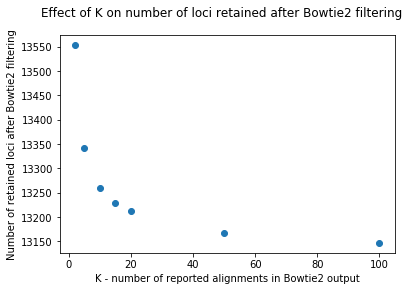

In [52]:
plt.scatter(ks, rem_loci)
plt.suptitle("Effect of K on number of loci retained after Bowtie2 filtering")
plt.xlabel("K - number of reported alignments in Bowtie2 output")
plt.ylabel("Number of retained loci after Bowtie2 filtering")
plt.show()

It looks like allowing for a ton of reported alignments only changes the number of retained loci by 400 loci, which is about .03%. In theory, Bowtie2 is only reporting back significant alignments, and allowing for more to be reported should eventually cease to have an effect on the numebr of retained loci. But if it's too computationally challenging then K = 2 is only .03% different than K = 100.